In [16]:
#import required libraries
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
#function to read prediction data file. Generally expeceted to have format of label,probability score
def read_pred_file(fl_name):
    df = pd.read_csv( fl_name)
    col1 = df.columns[0]
    print("[%d] records loaded from File[%s] " % (df[col1].count(),fl_name))
    
    return df

In [19]:
#set key variables.
ddir = '/disk1/data1/data/models/inception/'
model_name = 'incep_v3_he.cpkt'
steps = '15999'
pred_df_fl = ddir + model_name + '-' + steps + '_df.csv'


In [20]:
#load data
pred_df = read_pred_file(pred_df_fl)

[74448896] records loaded from File[/disk1/data1/data/models/inception/incep_v3_he.cpkt-15999_df.csv] 


In [21]:
#check data
print("Data columns: ",pred_df.columns)
print(pred_df.head())

Data columns:  Index(['label', 'prob'], dtype='object')
   label      prob
0    0.0  0.005524
1    0.0  0.004265
2    0.0  0.004293
3    0.0  0.002902
4    0.0  0.004698


In [22]:
#calculate ROC specific details and plot the grpah
fpr, tpr, _ = metrics.roc_curve(pred_df.label,  pred_df.prob)
auc = metrics.roc_auc_score(pred_df.label,  pred_df.prob)


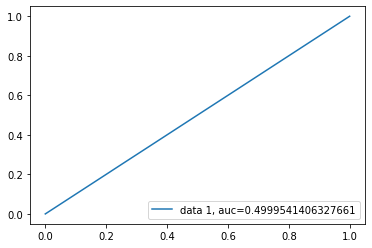

In [23]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [24]:
#Prepare predcition for confusion matrix. create prediction using optimal threshold, in our case threshold is .5
threshold = auc
#threshold = 0.1
pred_df['pred'] = pred_df.prob.apply(lambda x: 0. if x < threshold else 1.)

In [25]:
#print confusion matrix.
total = pred_df.label.count()

tot_1s = pred_df[(pred_df.label == 1.)]['label'].count()
tot_0s = pred_df[(pred_df.label == 0.)]['label'].count()
tp = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 1.)]['label'].count()
tn = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]['label'].count()
fp = pred_df[(pred_df.label == 0.) & (pred_df.pred == 1.)]['label'].count()
fn = pred_df[(pred_df.label == 1.) & (pred_df.pred == 0.)]['label'].count()
#print(" tp 1's : ",/tot_1s)
#print(" tp 0's : ",pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]['label'].count()/tot_0s)

In [26]:
print(" tp: ",tp," fp: ",fp)
print(" fn: ",fn," tn: ",tn)
print(" Total labels 1's: ",tot_1s," Total labels 0's: ",tot_0s)
print(" % labels 1's: ",tot_1s/total," % labels 0's: ",tot_0s/total)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(" Precision: ",precision)
print(" Recall: ",recall)
print(" F1 score: ",2*precision*recall/(precision+recall))


 tp:  200  fp:  13432
 fn:  1080852  tn:  73354412
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014671361502347418
 Recall:  0.00018500497663387146
 F1 score:  0.00036540225307029245


In [27]:
print(pred_df.head())
print(pred_df.pred.unique())
print(pred_df.label.unique())

   label      prob  pred
0    0.0  0.005524   0.0
1    0.0  0.004265   0.0
2    0.0  0.004293   0.0
3    0.0  0.002902   0.0
4    0.0  0.004698   0.0
[0. 1.]
[0. 1.]


In [28]:
fp_df = pred_df[(pred_df.label == 0.) & (pred_df.pred == 1.)]
fp_df.prob.describe()

count    13432.000000
mean         0.898235
std          0.119838
min          0.729993
25%          0.729994
50%          0.965098
75%          0.999704
max          0.999704
Name: prob, dtype: float64

In [29]:
fn_df = pred_df[(pred_df.label == 1.) & (pred_df.pred == 0.)]
fn_df.prob.describe()

count    1.080852e+06
mean     3.402758e-03
std      1.619498e-03
min      6.470978e-04
25%      2.671361e-03
50%      3.296733e-03
75%      3.984332e-03
max      1.611692e-01
Name: prob, dtype: float64

In [14]:
tn_df = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]
tn_df.prob.describe()


count    7.229045e+07
mean     3.563314e-03
std      5.016758e-03
min      1.904070e-04
25%      2.833366e-03
50%      3.332794e-03
75%      3.891259e-03
max      3.675114e-01
Name: prob, dtype: float64

In [15]:
print(tn_df.head())
print(fn_df.head())
print(tn_df.prob.describe())
print(fn_df.prob.describe())

   label      prob  pred
0    0.0  0.001972   0.0
1    0.0  0.004272   0.0
2    0.0  0.003694   0.0
3    0.0  0.003321   0.0
4    0.0  0.003823   0.0
         label      prob  pred
8204386    1.0  0.002200   0.0
8204390    1.0  0.003126   0.0
8204394    1.0  0.003967   0.0
8204395    1.0  0.002489   0.0
8204397    1.0  0.004136   0.0
count    7.229045e+07
mean     3.563314e-03
std      5.016758e-03
min      1.904070e-04
25%      2.833366e-03
50%      3.332794e-03
75%      3.891259e-03
max      3.675114e-01
Name: prob, dtype: float64
count    2.040302e+06
mean     3.493844e-03
std      5.078577e-03
min      1.927614e-04
25%      2.775759e-03
50%      3.261894e-03
75%      3.807873e-03
max      3.664449e-01
Name: prob, dtype: float64
